# 人脸重建
基于eos

In [24]:
import eos
import numpy as np
import cv2
from matplotlib import pyplot as plt

## 人脸关键点
使用opencv的人脸关键点检测模型

In [25]:
cas = cv2.CascadeClassifier('./facemodel/haarcascade_frontalface_alt2.xml')
obj = cv2.face.createFacemarkLBF()
obj.loadModel('./facemodel/lbfmodel.yaml')

loading data from : ./facemodel/lbfmodel.yaml


In [26]:
def detect_facepoint(img):
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = cas.detectMultiScale(img_gray,2,3,0,(30,30))
    landmarks = obj.fit(img_gray,faces)
    assert landmarks[0],'no face detected'
    if(len(landmarks[1])>1):
        print('multi face detected,use the first')
    return faces[0],np.squeeze(landmarks[1][0])

In [27]:
img_file = "./images/zly.jpg"

img = cv2.imread(img_file, -1)
print(img.shape)
face_box,coords = detect_facepoint(img)

landmarks = []
ibug_index = 1  # count from 1 to 68 for all ibug landmarks
for l in range(coords.shape[0]):
    landmarks.append(eos.core.Landmark(str(ibug_index), [float(coords[ibug_index-1][0]), float(coords[ibug_index-1][1])]))
    ibug_index = ibug_index + 1

(519, 489, 3)


In [28]:
def vis_img(img):
    plt.imshow(cv2.cvtColor(img.copy(),cv2.COLOR_BGR2RGB))

(-0.5, 488.5, 518.5, -0.5)

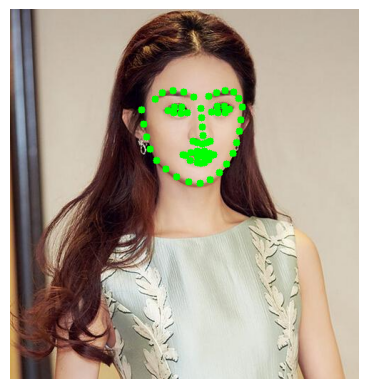

In [29]:
#可视化关键点
img_show = img.copy()
for kps in landmarks:
    face_kps = kps.coordinates
    # print(face_kps)
    cv2.circle(img_show,(int(face_kps[0]),int(face_kps[1])),5,(0,255,0),-1) # cv2.circle只接受整数坐标
vis_img(img_show)
plt.axis('off')

## 重建人脸

In [30]:
image_height = img.shape[0]
image_width = img.shape[1]

In [31]:
'''
为img添加alpha通道，注意必须np.ones不能np.zeros，否则会报错
'''

# 创建一个全为255（不透明）的Alpha通道
alpha_channel = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.uint8) * 255 #很奇怪，为什么必须np.ones，不管是这里还是我之前自己写的[m, n, 3]->[m, n, 4]，使用np.zeros都会报incomptaible的错误

# 合并RGB图像和Alpha通道
img = np.concatenate((img, alpha_channel), axis=2)

# # 保存结果
# cv2.imwrite('output_rgba.png', img)

In [32]:
# 初始化eos
model = eos.morphablemodel.load_model("./eos/share/sfm_shape_3448.bin")
blendshapes = eos.morphablemodel.load_blendshapes("./eos/share/expression_blendshapes_3448.bin")
# Create a MorphableModel with expressions from the loaded neutral model and blendshapes:
morphablemodel_with_expressions = eos.morphablemodel.MorphableModel(model.get_shape_model(), blendshapes,
                                                                    color_model=eos.morphablemodel.PcaModel(),
                                                                    vertex_definitions=None,
                                                                    texture_coordinates=model.get_texture_coordinates())
landmark_mapper = eos.core.LandmarkMapper('./eos/share/ibug_to_sfm.txt')
edge_topology = eos.morphablemodel.load_edge_topology('./eos/share/sfm_3448_edge_topology.json')
contour_landmarks = eos.fitting.ContourLandmarks.load('./eos/share/ibug_to_sfm.txt')
model_contour = eos.fitting.ModelContour.load('./eos/share/sfm_model_contours.json')

In [33]:
# 重建人脸
(mesh, pose, shape_coeffs, blendshape_coeffs) = eos.fitting.fit_shape_and_pose(morphablemodel_with_expressions,
        landmarks, landmark_mapper, image_width, image_height, edge_topology, contour_landmarks, model_contour)
mesh, pose, shape_coeffs, blendshape_coeffs

(<eos.core.Mesh with 3448 vertices, 6736 tvi, 0 colour values, 0 tci, 3448 texcoords, 0 tti>,
 [-0.2824060916900635,
  0.14904052019119263,
  -0.24829378724098206,
  -0.40231090784072876,
  0.639101505279541,
  -0.3174881637096405,
  -0.0006162793142721057,
  -0.7738372087478638,
  -0.09592686593532562,
  0.3339996635913849,
  0.32455724477767944,
  0.11715469509363174,
  -0.5562846064567566,
  -0.007689664606004953,
  0.24306458234786987,
  -0.1585478037595749,
  -0.1179521381855011,
  0.14745891094207764,
  -0.18725472688674927,
  -0.14180795848369598,
  -0.15342599153518677,
  0.13595880568027496,
  0.17454037070274353,
  0.26534533500671387,
  -0.004727657418698072,
  -0.1063137948513031,
  -0.005284903571009636,
  -0.23340262472629547,
  -0.1502404510974884,
  -0.2196163386106491,
  0.2107008695602417,
  -0.17623794078826904,
  -0.020037781447172165,
  -0.14730167388916016,
  -0.1736277937889099,
  0.10432609915733337,
  0.0017466945573687553,
  0.16492456197738647,
  0.0019849264

(-0.5, 511.5, 511.5, -0.5)

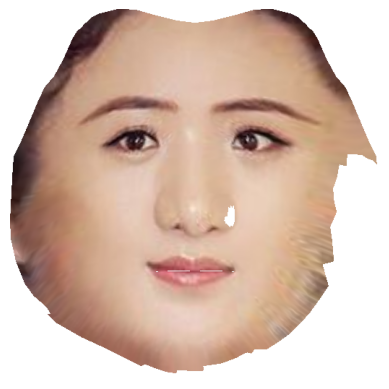

In [34]:
# 提取纹理
isomap = eos.render.extract_texture(mesh,pose,img)# .swapaxes(0,1) 使用swap反而方向错了
cv2.imwrite("result.isomap.png",isomap)
vis_img(isomap)
plt.axis('off')

In [35]:
def blendshape_add(bss,bc):
    bs_array = []
    for bs in bss:
        bs_array.append(bs.deformation)
    bs_array = np.array(bs_array).transpose()
    bc = np.array(bc)
    return np.dot(bs_array,bc)

In [36]:
# 改变表情 anger, disgust, fear, happiness, sadness, surprise
blendshape_coeffs = [0,1,0,0,0,0]
merge_shape = morphablemodel_with_expressions.get_shape_model().draw_sample(shape_coeffs) + blendshape_add(blendshapes,blendshape_coeffs);

In [37]:
merged_mesh = eos.morphablemodel.sample_to_mesh(merge_shape,morphablemodel_with_expressions.get_color_model().get_mean(),morphablemodel_with_expressions.get_shape_model().get_triangle_list(),morphablemodel_with_expressions.get_color_model().get_triangle_list(),morphablemodel_with_expressions.get_texture_coordinates());

In [38]:
outputfile = "result.obj"
eos.core.write_textured_obj(merged_mesh,outputfile);

## 渲染图像

In [39]:
triangles = np.array(merged_mesh.tvi) # 人脸网格对应的顶点索引
# 人脸顶点
vertices = []
for v in merged_mesh.vertices:
    vertices.append(np.array([v[0],-v[1],v[2]]))
vertices = np.array(vertices)
vertices = vertices-np.min(vertices)
# 纹理坐标
texcoords = []
for tc in merged_mesh.texcoords:
    texcoords.append(tc)
texcoords = np.array(texcoords)
# 根据纹理坐标获取每个顶点的颜色
colors = []
for i in range(texcoords.shape[0]):
    colors.append(isomap[int(texcoords[i][1]*(isomap.shape[0]-1)),int(texcoords[i][0]*(isomap.shape[1]-1)),0:3])
colors = np.array(colors,np.float32)

In [40]:
#获取三角形每个顶点的color，平均值作为三角形颜色
tri_tex = (colors[triangles[:,0] ,:] + colors[triangles[:,1],:] + colors[triangles[:,2],:])/3.

In [41]:
img_3D = np.zeros_like(img,dtype=np.uint8)
for i in range(triangles.shape[0]):
    cnt = np.array([(vertices[triangles[i,0],0],vertices[triangles[i,0],1]),
           (vertices[triangles[i,1],0],vertices[triangles[i,1],1]),
           (vertices[triangles[i,2],0],vertices[triangles[i,2],1])],dtype=np.int32)
    img_3D = cv2.drawContours(img_3D,[cnt],0,(int(tri_tex[i][0]), int(tri_tex[i][1]), int(tri_tex[i][2])),-1)

(-0.5, 488.5, 518.5, -0.5)

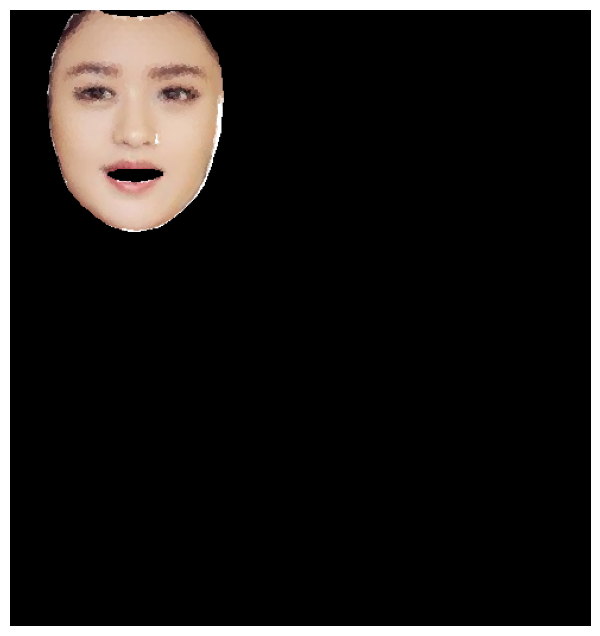

In [42]:
plt.figure(figsize=(8,8))
vis_img(img_3D)
plt.axis('off')

## GIF
利用表情系数制作一个gif表情看看

In [43]:
import imageio

In [44]:
buff = []
frame_num = 20
for i in range(frame_num): #一个gif 10帧
    # 改变表情 anger, disgust, fear, happiness, sadness, surprise
    blendshape_coeffs = [1.0 - i/frame_num,0,0,0,0,i/frame_num]
    merge_shape = morphablemodel_with_expressions.get_shape_model().draw_sample(shape_coeffs) + blendshape_add(blendshapes,blendshape_coeffs);
    merged_mesh = eos.morphablemodel.sample_to_mesh(merge_shape,morphablemodel_with_expressions.get_color_model().get_mean(),morphablemodel_with_expressions.get_shape_model().get_triangle_list(),morphablemodel_with_expressions.get_color_model().get_triangle_list(),morphablemodel_with_expressions.get_texture_coordinates());
    triangles = np.array(merged_mesh.tvi) # 人脸网格对应的顶点索引
    # 人脸顶点
    vertices = []
    for v in merged_mesh.vertices:
        vertices.append(np.array([v[0],-v[1],v[2]]))
    vertices = np.array(vertices)
    vertices = vertices-np.min(vertices)
    # 纹理坐标
    texcoords = []
    for tc in merged_mesh.texcoords:
        texcoords.append(tc)
    texcoords = np.array(texcoords)
    # 根据纹理坐标获取每个顶点的颜色
    colors = []
    for i in range(texcoords.shape[0]):
        colors.append(isomap[int(texcoords[i][1]*(isomap.shape[0]-1)),int(texcoords[i][0]*(isomap.shape[1]-1)),0:3])
    colors = np.array(colors,np.float32)
    #获取三角形每个顶点的color，平均值作为三角形颜色
    tri_tex = (colors[triangles[:,0] ,:] + colors[triangles[:,1],:] + colors[triangles[:,2],:])/3.
    img_3D = np.zeros_like(img,dtype=np.uint8)
    for i in range(triangles.shape[0]):
        cnt = np.array([(vertices[triangles[i,0],0],vertices[triangles[i,0],1]),
               (vertices[triangles[i,1],0],vertices[triangles[i,1],1]),
               (vertices[triangles[i,2],0],vertices[triangles[i,2],1])],dtype=np.int32)
        img_3D = cv2.drawContours(img_3D,[cnt],0,(int(tri_tex[i][0]), int(tri_tex[i][1]), int(tri_tex[i][2])),-1)
    buff.append(cv2.cvtColor(img_3D,cv2.COLOR_BGR2RGB))
gif=imageio.mimsave('expression.gif',buff,'GIF',duration=0.1)